
-----
#### MS: Unique patterns of mutations in childhood cancer highlight chemotherapy’s disease-defining role at relapse
### Extended Data Figure 8
-----

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

-----
##### Set up input / output directories

In [3]:
## Provide an output directory for figures or use 'installation_folder/figures' directory
root_dir = os.path.dirname(os.getcwd())
fig_out = os.path.join(root_dir, 'figures')
## Or provide a results path
#fig_out = '/Users/dir1/dir2/Figures'

-----
##### Load helper scripts

In [4]:
sys.path.append(str(root_dir))
import scripts.ml_utils as mu

/Users/mehdi/Documents/py_envs/ml_sigs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
##### Load & prepare data 

In [89]:
## Load patients metadata
kzm611_md = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_md_rev.txt'), sep='\t', index_col=0)
low_samples = kzm611_md[kzm611_md.SBS_Burden=='low'].index.tolist()

In [90]:
kzm_types = pd.concat([kzm611_md[kzm611_md.Cohort=='KiCS'].Type.value_counts(),
                       kzm611_md[kzm611_md.Cohort=='ZCC'].Type.value_counts(),
                       kzm611_md[kzm611_md.Cohort=='MSK'].Type.value_counts()], axis=1)
kzm_types.columns = ['KiCS', 'ZCC', 'MSK']
kzm_types = kzm_types.fillna(0).astype(int)
kzm_types['Total'] = kzm_types.sum(axis=1)

kzm_types_sorted = kzm_types.sort_values(['Total'], ascending=False)
#kzm_types_sorted = kzm_types_sorted.drop(['Total'], axis=1)

kzm_types_sorted.head(10)

,KiCS,ZCC,MSK,Total
Type,,,,
NBL,48,23,17,88
HGG,23,30,1,54
OST,19,10,15,44
BALL,21,13,0,34
EWS,10,18,2,30
ERMS,15,6,5,26
DMG,4,22,0,26
ARMS,9,11,1,21
WT,12,4,2,18


In [91]:
pog570_md = pd.read_csv(os.path.join(root_dir, 'source_data/POG_data/POG_patients.tsv'), sep='\t', index_col=0)
pog570_md.head(2)

,SAMPLE_ID_DNA,SAMPLE_ID_RNA,AGE,GENDER,TUMOUR_TYPE,HISTOLOGICAL_TYPE,BIOPSY_SITE,BIOPSY_COHORT,ANALYSIS_COHORT,PRIMARY_SITE,METASTATIC_OR_RECURRENCE,TUMOUR_CONTENT,EGAD_ID
PATIENT_ID,,,,,,,,,,,,,
11004,A10504,A10506,30,F,Colorectal Adenocarcinoma,COAD,Liver,Liver,COLO,Colon,Metastatic,73,EGAD00001001307
11307,A10512,A10513,48,F,Breast Invasive Ductal Carcinoma,IDC,Liver,Liver,BRCA,Breast,Metastatic,59,EGAD00001002017


In [92]:
pog_types = pd.DataFrame(pog570_md.HISTOLOGICAL_TYPE.value_counts())

In [93]:
kzm_colors = {x: 'red' if x in pog570_md.HISTOLOGICAL_TYPE.unique().tolist() else 'black' for x in kzm611_md.Type.unique()}
pog_colors = {x: 'red' if x in kzm611_md.Type.unique().tolist() else 'black' for x in pog570_md.HISTOLOGICAL_TYPE.unique()}

-----
## Panel a

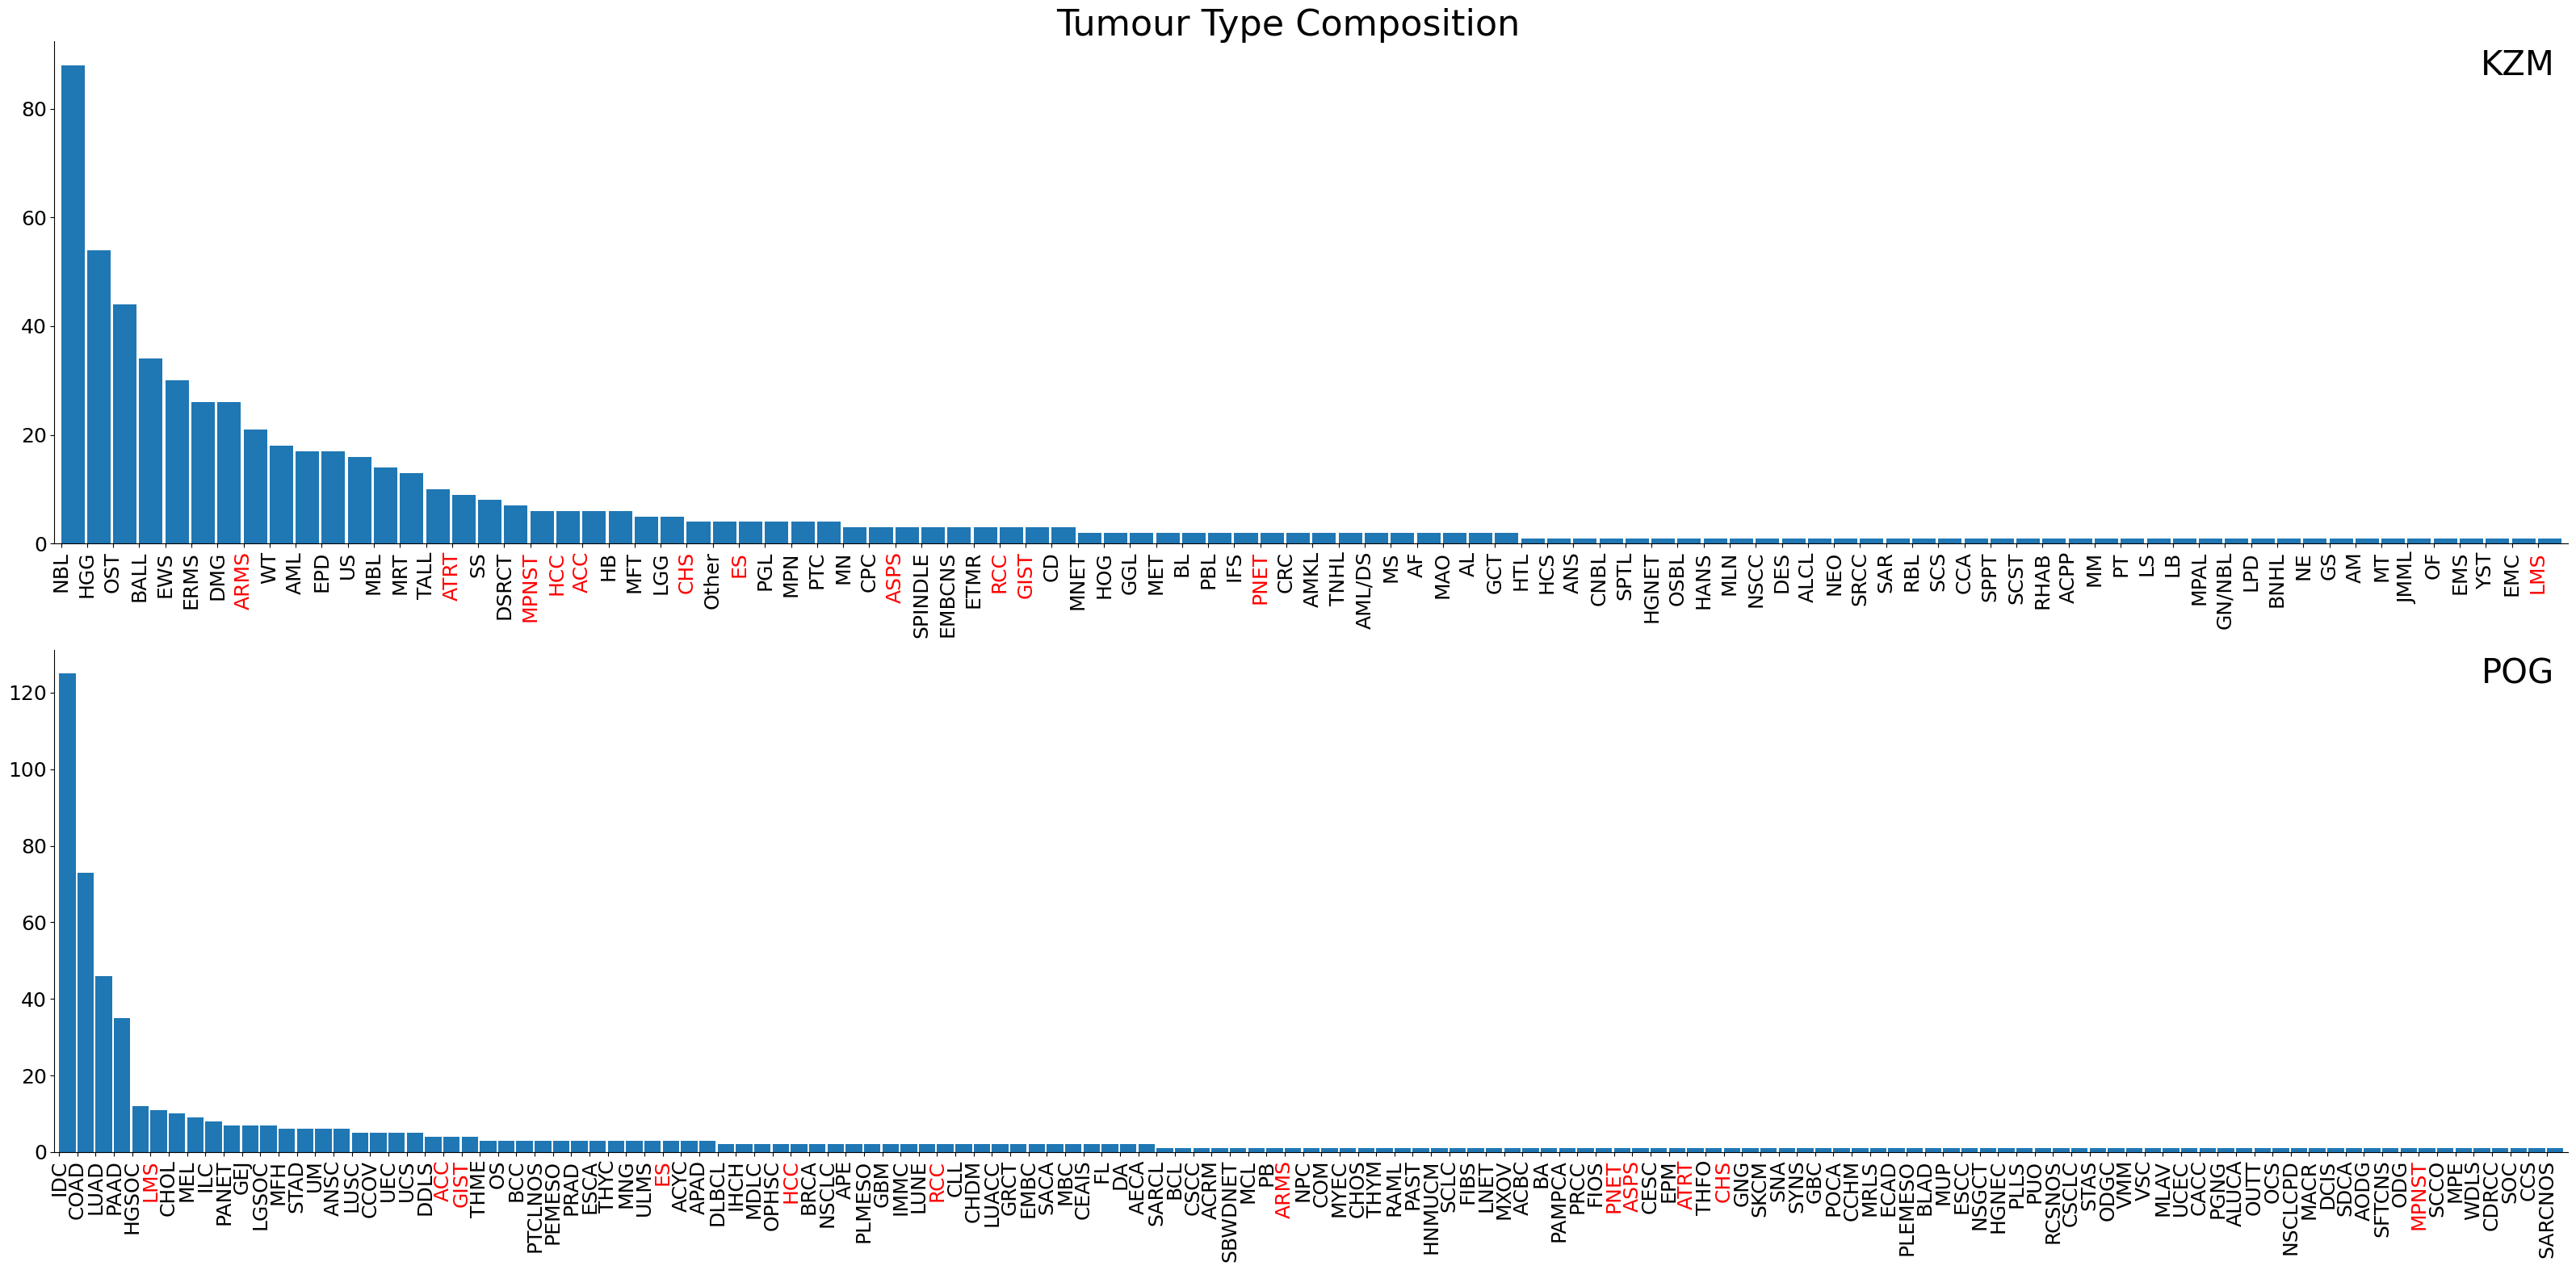

In [95]:
fig, axes = plt.subplots(2,1, figsize=(32, 16))#, gridspec_kw={'height_ratios': [5, 2]})

ax1 = kzm611_md.Type.value_counts().plot.bar(width=0.9, align='edge', ax=axes[0])
ax1.set_xticklabels(kzm_types_sorted.index, fontsize=18)
ax1.set_title('KZM', fontsize=30, y=1.0, x=0.98, pad=-30)
ax1.set_xlabel('')
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.spines[['right', 'top']].set_visible(False)

labels = ax1.get_xticklabels()
for label in labels:
    label.set_color(kzm_colors[label.get_text()])

ax2 = pog570_md.HISTOLOGICAL_TYPE.value_counts().plot.bar(width=0.9, align='edge', ax=axes[1])
ax2.set_xticklabels(pog_types.index, fontsize=18)
ax2.set_title('POG', fontsize=30, y=1, x=0.98, pad=-30)
ax2.set_xlabel('')
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.spines[['right', 'top']].set_visible(False)

labels = ax2.get_xticklabels()
for label in labels:
    label.set_color(pog_colors[label.get_text()])

fig.suptitle('Tumour Type Composition', fontsize=32)

plt.tight_layout()

plt.savefig(os.path.join(fig_out, 'ExFig_8a_rev.pdf'), bbox_inches="tight")

-----
## Panel b

In [10]:
## Load therapy data at class and individual drug levels
class_df = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_therapy_classes_NY.txt'), sep='\t', index_col=0)

In [11]:
selected_therapies = ['Platinums', 'Anthracyclines', 'Antimetabolite', 'Camptothecin analogs', 'Chromomycins',
                    'Hydrazines and Triazines', 'Mustard gas derivative', 'Podophyllotoxins', 'Vinca alkaloids',
                    'Alkylating agent, Other', 'Taxanes', 'Topoisomerase II inhibitor']

In [12]:
drug_classes = pd.read_csv(os.path.join(root_dir, 'source_data/Therapy_categories.tsv'), sep='\t', engine='python')
drug_class_dict = dict(zip(drug_classes.Drug, drug_classes.Class))
drug_subclass_dict = dict(zip(drug_classes.Drug, drug_classes.Subclass))

In [13]:
pog_drugs = mu.load_pog_drugs()
pog_drugs.columns = [x.lower().capitalize() for x in pog_drugs.columns]
pog_drugs_class = pog_drugs[[x for x in pog_drugs.columns if x in list(drug_subclass_dict.keys())]].copy()
pog_drugs_class.columns = [drug_subclass_dict[x] for x in pog_drugs_class.columns]
pog_drugs_class = pog_drugs_class.groupby(pog_drugs_class.columns, axis=1).sum()
for col in pog_drugs_class.columns:
    pog_drugs_class[col] = ['Y' if 'Y' in x else 'N' for x in pog_drugs_class[col]]
pog_drugs_class.head()

,"Alkylating agent, Other",Anthracyclines,Antimetabolite,Antitumor antibiotic,Camptothecin analogs,Chromomycins,Hydrazines and Triazines,Monoclonal antibody,Mustard gas derivative,Other,Platinums,Podophyllotoxins,Targeted therapy,Taxanes,Vinca alkaloids
POG_37862,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
POG_28132,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N
POG_27723,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
POG_30505,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
POG_34117,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N


In [14]:
from sklearn.metrics.pairwise import pairwise_distances

In [68]:
[x for x in pog_drugs.columns if x.startswith('Rad')]

[]

In [16]:
#pog_drugs = mu.load_pog_drugs()
pog_class_hm = pog_drugs_class.copy()
pog_class_hm = pog_class_hm.drop(['Other'], axis=1)
pog_drug_list = pog_class_hm.columns.tolist()
pog_class_hm = pog_class_hm.replace('N', 0)
pog_class_hm = pog_class_hm.replace('Y', 1)

kzm_class_hm = class_df.copy()
kzm_class_hm = kzm_class_hm[~kzm_class_hm.isin(['M']).any(axis=1)]

kzm_class_hm = kzm_class_hm.drop(['Therapy'], axis=1)
kzm_drug_list = kzm_class_hm.columns.tolist()
kzm_class_hm = kzm_class_hm.replace('N', 0)
kzm_class_hm = kzm_class_hm.replace('Y', 1)

pog_class_hm = pd.DataFrame(np.array(pog_class_hm, dtype=int))
kzm_class_hm = pd.DataFrame(np.array(kzm_class_hm, dtype=int))

pog_jacc = 1 - pd.DataFrame(pairwise_distances(pog_class_hm.T.to_numpy(), metric='jaccard'))
pog_jacc.index = pog_jacc.columns = pog_drug_list

kzm_jacc = 1 - pd.DataFrame(pairwise_distances(kzm_class_hm.T.to_numpy(), metric='jaccard'))
kzm_jacc.index = kzm_jacc.columns = kzm_drug_list


/Users/mehdi/Documents/py_envs/ml_sigs/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/mehdi/Documents/py_envs/ml_sigs/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [17]:
kzm_class_hm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0
1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
3,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


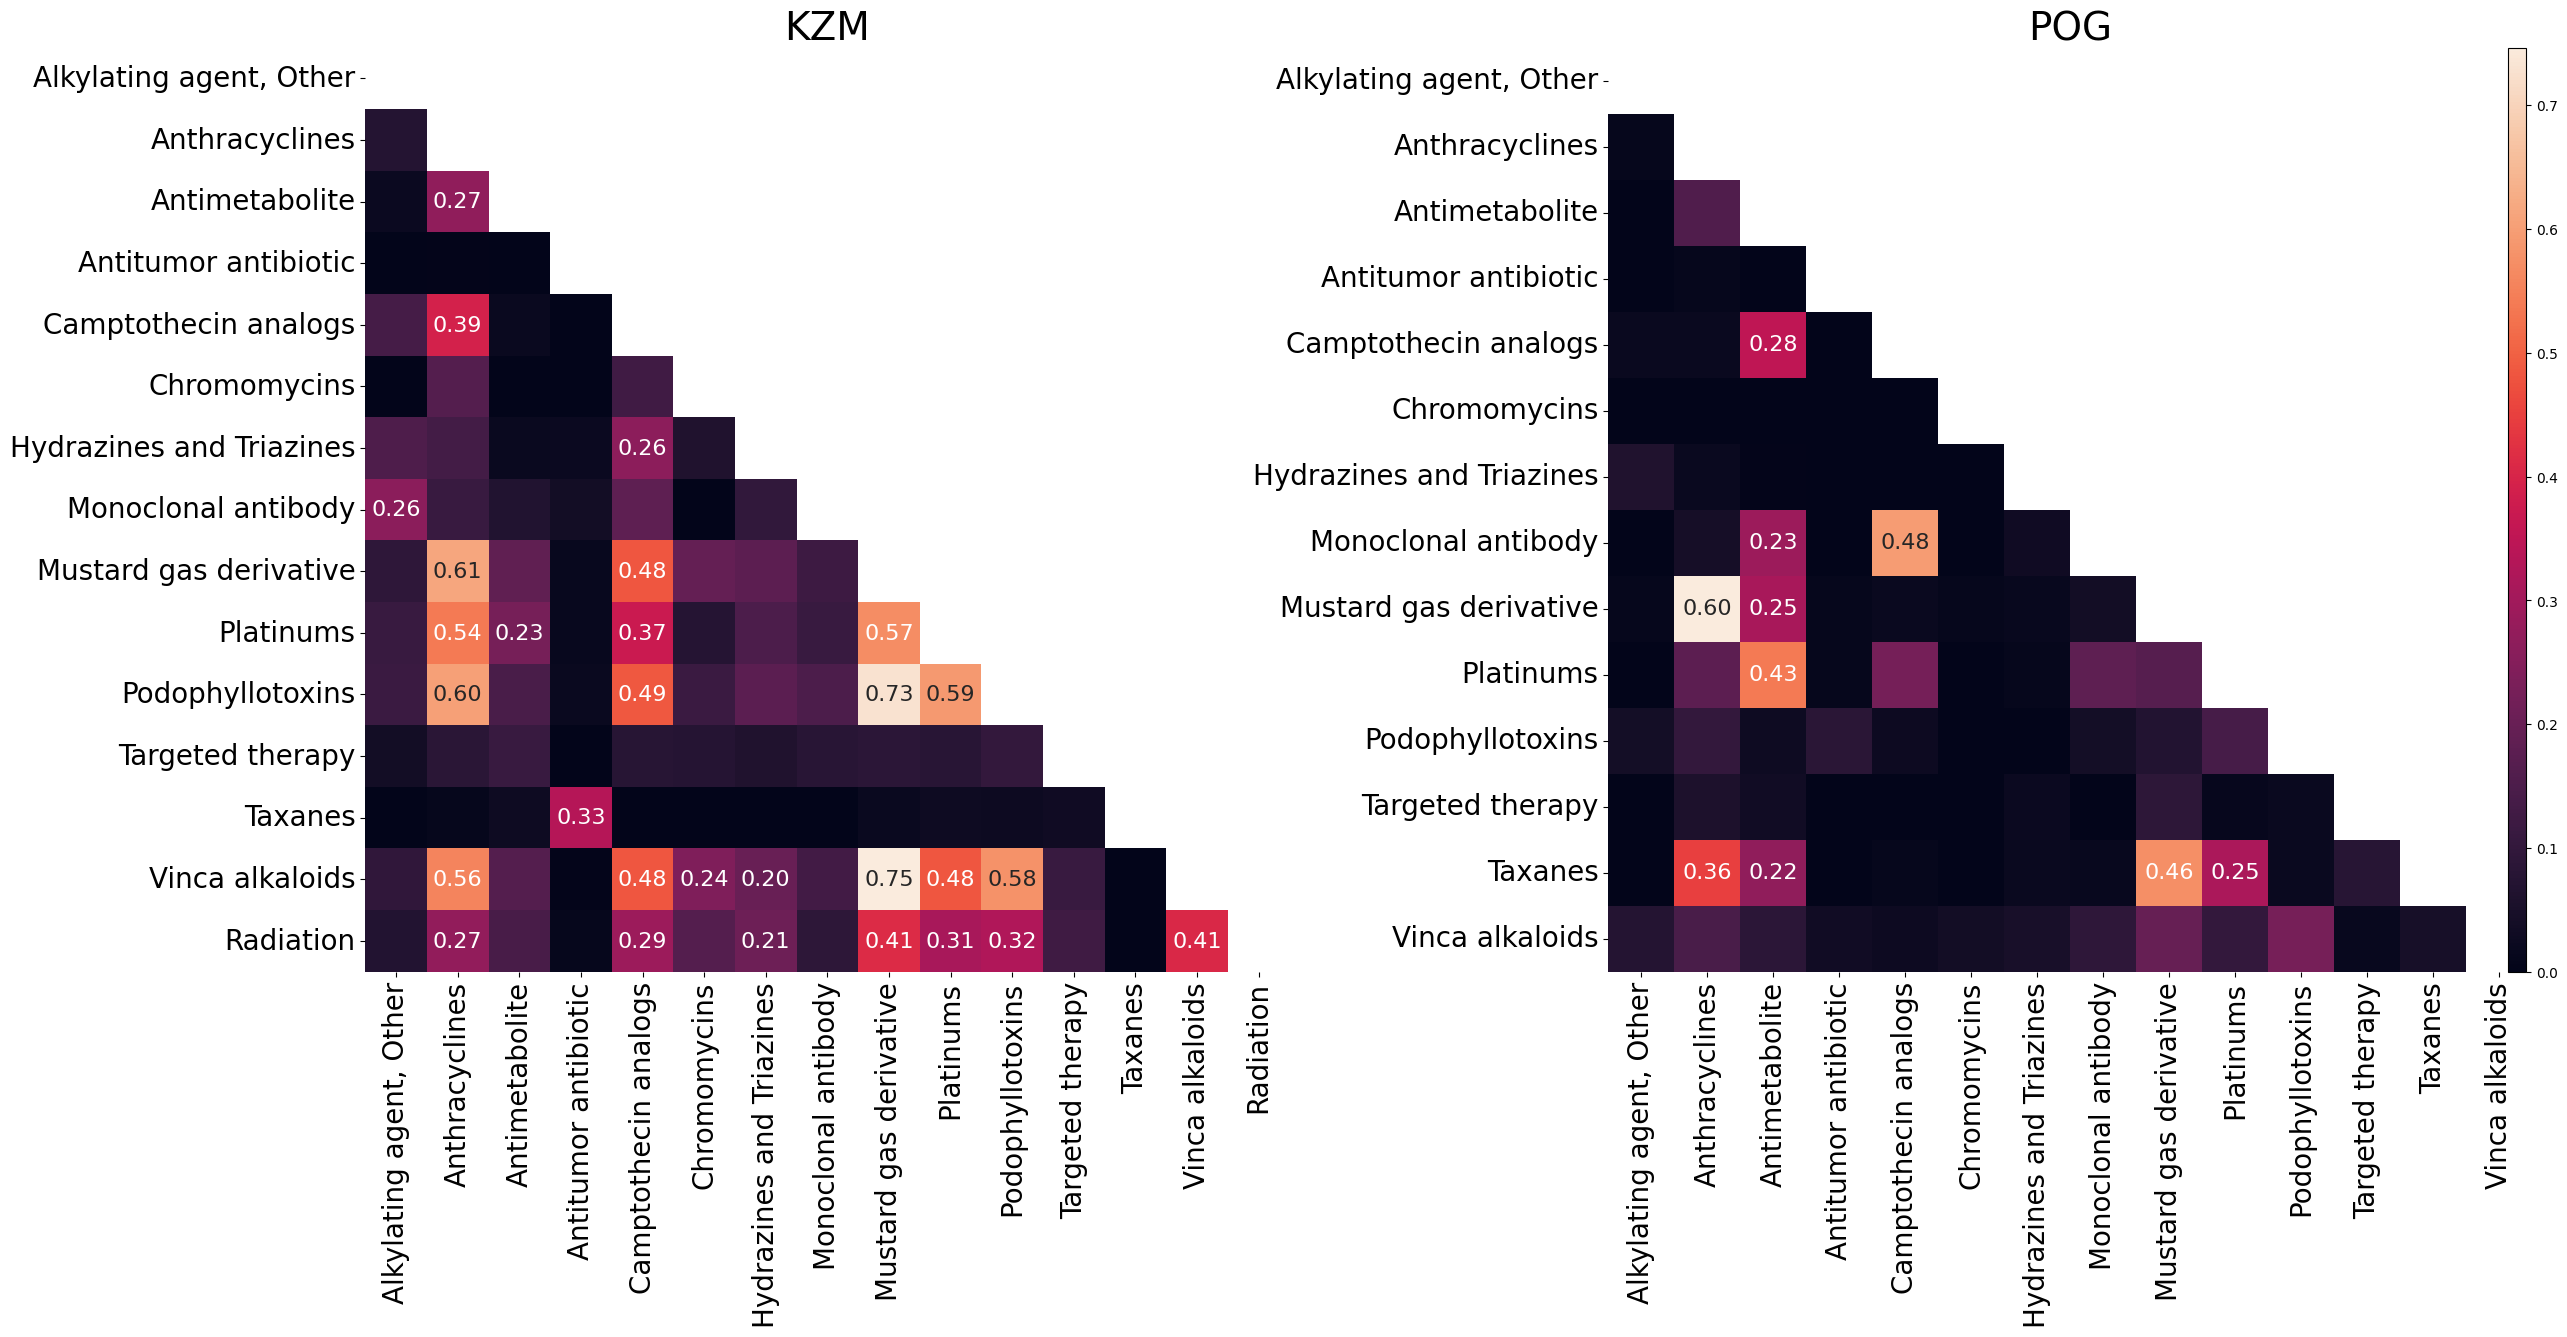

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(32,12))

kzm_mask = np.zeros_like(kzm_jacc)
kzm_mask[np.triu_indices_from(kzm_mask)] = True
pog_mask = np.zeros_like(pog_jacc)
pog_mask[np.triu_indices_from(pog_mask)] = True

ax1 = sns.heatmap(kzm_jacc, mask=kzm_mask, square=True, annot=True, fmt='0.2f', ax=axes[0], cbar=False, annot_kws={"size": 16}, cbar_kws={"orientation": "horizontal"})
ax2 = sns.heatmap(pog_jacc, mask=pog_mask, square=True, annot=True, fmt='0.2f', ax=axes[1], cbar=False, annot_kws={"size": 16}, cbar_kws={"orientation": "horizontal"})

ax1.set_title('KZM', fontsize=28)
ax2.set_title('POG', fontsize=28)

mappable = ax1.get_children()[0]
plt.colorbar(mappable, ax = [axes[0],axes[1]], fraction=0.01, pad=0.01, aspect=50)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=20)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)

for t in ax1.texts:
    if float(t.get_text())>=0.2:
        t.set_text(t.get_text())
    else:
        t.set_text("")
for t in ax2.texts:
    if float(t.get_text())>=0.2:
        t.set_text(t.get_text())
    else:
        t.set_text("")

plt.subplots_adjust(wspace=0.005)

plt.savefig(os.path.join(fig_out, 'ExFig_8b.pdf'), bbox_inches="tight")

In [23]:
pog_class_hm = pog_drugs_class.copy()
pog_class_hm = pog_class_hm.drop(['Other'], axis=1)
pog_drug_list = pog_class_hm.columns.tolist()
pog_class_hm = pog_class_hm.replace('N', 0)
pog_class_hm = pog_class_hm.replace('Y', 1)

kzm_class_hm = class_df.copy()
kzm_class_hm = kzm_class_hm[~kzm_class_hm.isin(['M']).any(axis=1)]

kzm_class_hm = kzm_class_hm.drop(['Therapy'], axis=1)
kzm_drug_list = kzm_class_hm.columns.tolist()
kzm_class_hm = kzm_class_hm.replace('N', 0)
kzm_class_hm = kzm_class_hm.replace('Y', 1)

In [21]:
corr_matrix = kzm_class_hm.corr()
corr_matrix.columns = corr_matrix.index = kzm_drug_list

In [22]:
corr_matrix

,"Alkylating agent, Other",Anthracyclines,Antimetabolite,Antitumor antibiotic,Camptothecin analogs,Chromomycins,Hydrazines and Triazines,Monoclonal antibody,Mustard gas derivative,Platinums,Podophyllotoxins,Targeted therapy,Taxanes,Vinca alkaloids,Radiation
"Alkylating agent, Other",1.000000,0.082683,-0.043627,-0.017827,0.219670,-0.071151,0.220988,0.383774,0.156719,0.221064,0.202126,0.020973,-0.023059,0.155371,0.064528
Anthracyclines,0.082683,1.000000,0.336199,-0.002662,0.460837,0.240485,0.174291,0.220144,0.623772,0.542942,0.633134,0.110749,0.010329,0.560440,0.264956
Antimetabolite,-0.043627,0.336199,1.000000,-0.030538,-0.150478,-0.121885,-0.075967,0.061314,0.168991,0.248704,0.084409,0.151045,0.074613,0.126075,0.105794
Antitumor antibiotic,-0.017827,-0.002662,-0.030538,1.000000,-0.036709,-0.023160,0.071932,0.099030,0.097540,0.107884,0.114781,-0.018172,0.512896,-0.002662,0.028218
Camptothecin analogs,0.219670,0.460837,-0.150478,-0.036709,1.000000,0.136185,0.388155,0.318129,0.596783,0.421586,0.576705,0.081110,-0.047483,0.584552,0.321018
Chromomycins,-0.071151,0.240485,-0.121885,-0.023160,0.136185,1.000000,0.039249,-0.069750,0.318085,0.005302,0.113174,0.080537,-0.029957,0.414329,0.206860
Hydrazines and Triazines,0.220988,0.174291,-0.075967,0.071932,0.388155,0.039249,1.000000,0.129327,0.301072,0.217470,0.270472,0.056662,-0.028827,0.338858,0.296923
Monoclonal antibody,0.383774,0.220144,0.061314,0.099030,0.318129,-0.069750,0.129327,1.000000,0.257380,0.212550,0.307380,0.101640,-0.022605,0.275642,0.115068
Mustard gas derivative,0.156719,0.623772,0.168991,0.097540,0.596783,0.318085,0.301072,0.257380,1.000000,0.584405,0.772354,0.129834,0.085544,0.773377,0.495415
Platinums,0.221064,0.542942,0.248704,0.107884,0.421586,0.005302,0.217470,0.212550,0.584405,1.000000,0.621002,0.102791,0.139548,0.465929,0.327659


In [27]:
kzm_jacc

,"Alkylating agent, Other",Anthracyclines,Antimetabolite,Antitumor antibiotic,Camptothecin analogs,Chromomycins,Hydrazines and Triazines,Monoclonal antibody,Mustard gas derivative,Platinums,Podophyllotoxins,Targeted therapy,Taxanes,Vinca alkaloids,Radiation
"Alkylating agent, Other",1.000000,0.071795,0.020619,0.000000,0.136364,0.000000,0.152542,0.261905,0.092683,0.117318,0.113772,0.037736,0.000000,0.094241,0.068376
Anthracyclines,0.071795,1.000000,0.270000,0.005435,0.393035,0.164948,0.131980,0.112299,0.612766,0.536797,0.600939,0.082474,0.010811,0.555556,0.272727
Antimetabolite,0.020619,0.270000,1.000000,0.000000,0.017964,0.000000,0.018018,0.065217,0.185022,0.225000,0.143564,0.111111,0.026667,0.165138,0.140940
Antitumor antibiotic,0.000000,0.005435,0.000000,1.000000,0.000000,0.000000,0.023256,0.035714,0.015228,0.017341,0.018868,0.000000,0.333333,0.005435,0.010000
Camptothecin analogs,0.136364,0.393035,0.017964,0.000000,1.000000,0.126984,0.263636,0.180952,0.482412,0.368687,0.485549,0.076923,0.000000,0.481481,0.289474
Chromomycins,0.000000,0.164948,0.000000,0.000000,0.126984,1.000000,0.062500,0.000000,0.193069,0.074257,0.115385,0.074627,0.000000,0.241758,0.163934
Hydrazines and Triazines,0.152542,0.131980,0.018018,0.023256,0.263636,0.062500,1.000000,0.098361,0.178218,0.150538,0.176471,0.061538,0.000000,0.198925,0.208696
Monoclonal antibody,0.261905,0.112299,0.065217,0.035714,0.180952,0.000000,0.098361,1.000000,0.120603,0.111732,0.149068,0.080000,0.000000,0.130435,0.087719
Mustard gas derivative,0.092683,0.612766,0.185022,0.015228,0.482412,0.193069,0.178218,0.120603,1.000000,0.574468,0.728155,0.086957,0.020202,0.746544,0.411483
Platinums,0.117318,0.536797,0.225000,0.017341,0.368687,0.074257,0.150538,0.111732,0.574468,1.000000,0.588517,0.080645,0.028902,0.479167,0.309179


In [24]:
kzm_class_hm.head()

,"Alkylating agent, Other",Anthracyclines,Antimetabolite,Antitumor antibiotic,Camptothecin analogs,Chromomycins,Hydrazines and Triazines,Monoclonal antibody,Mustard gas derivative,Platinums,Podophyllotoxins,Targeted therapy,Taxanes,Vinca alkaloids,Radiation
KiCS0002_321321,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0
KiCS0003_285201,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
KiCS0003_285202,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
KiCS0003_20_15220_A_02_00,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1
KiCS0005_300238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
kzm_class_hm[(kzm_class_hm.Platinums>0) & (kzm_class_hm.Antimetabolite>0)].shape[0] / kzm_class_hm[kzm_class_hm.Antimetabolite>0].shape[0]

0.625

In [41]:
kzm_class_hm[(kzm_class_hm.Platinums>0) & (kzm_class_hm['Mustard gas derivative']>0)].shape[0] / kzm_class_hm[kzm_class_hm['Mustard gas derivative']>0].shape[0]

0.6852791878172588

In [47]:
kzm_class_hm[(kzm_class_hm.Platinums>0) & (kzm_class_hm.Anthracyclines>0)].shape[0] / kzm_class_hm[kzm_class_hm.Anthracyclines>0].shape[0]

0.6813186813186813

In [44]:
df.head()

,"Alkylating agent, Other",Anthracyclines,Antimetabolite,Antitumor antibiotic,Camptothecin analogs,Chromomycins,Hydrazines and Triazines,Monoclonal antibody,Mustard gas derivative,Platinums,Podophyllotoxins,Targeted therapy,Taxanes,Vinca alkaloids,Radiation
KiCS0002_321321,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0
KiCS0003_285201,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
KiCS0003_285202,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
KiCS0003_20_15220_A_02_00,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1
KiCS0005_300238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


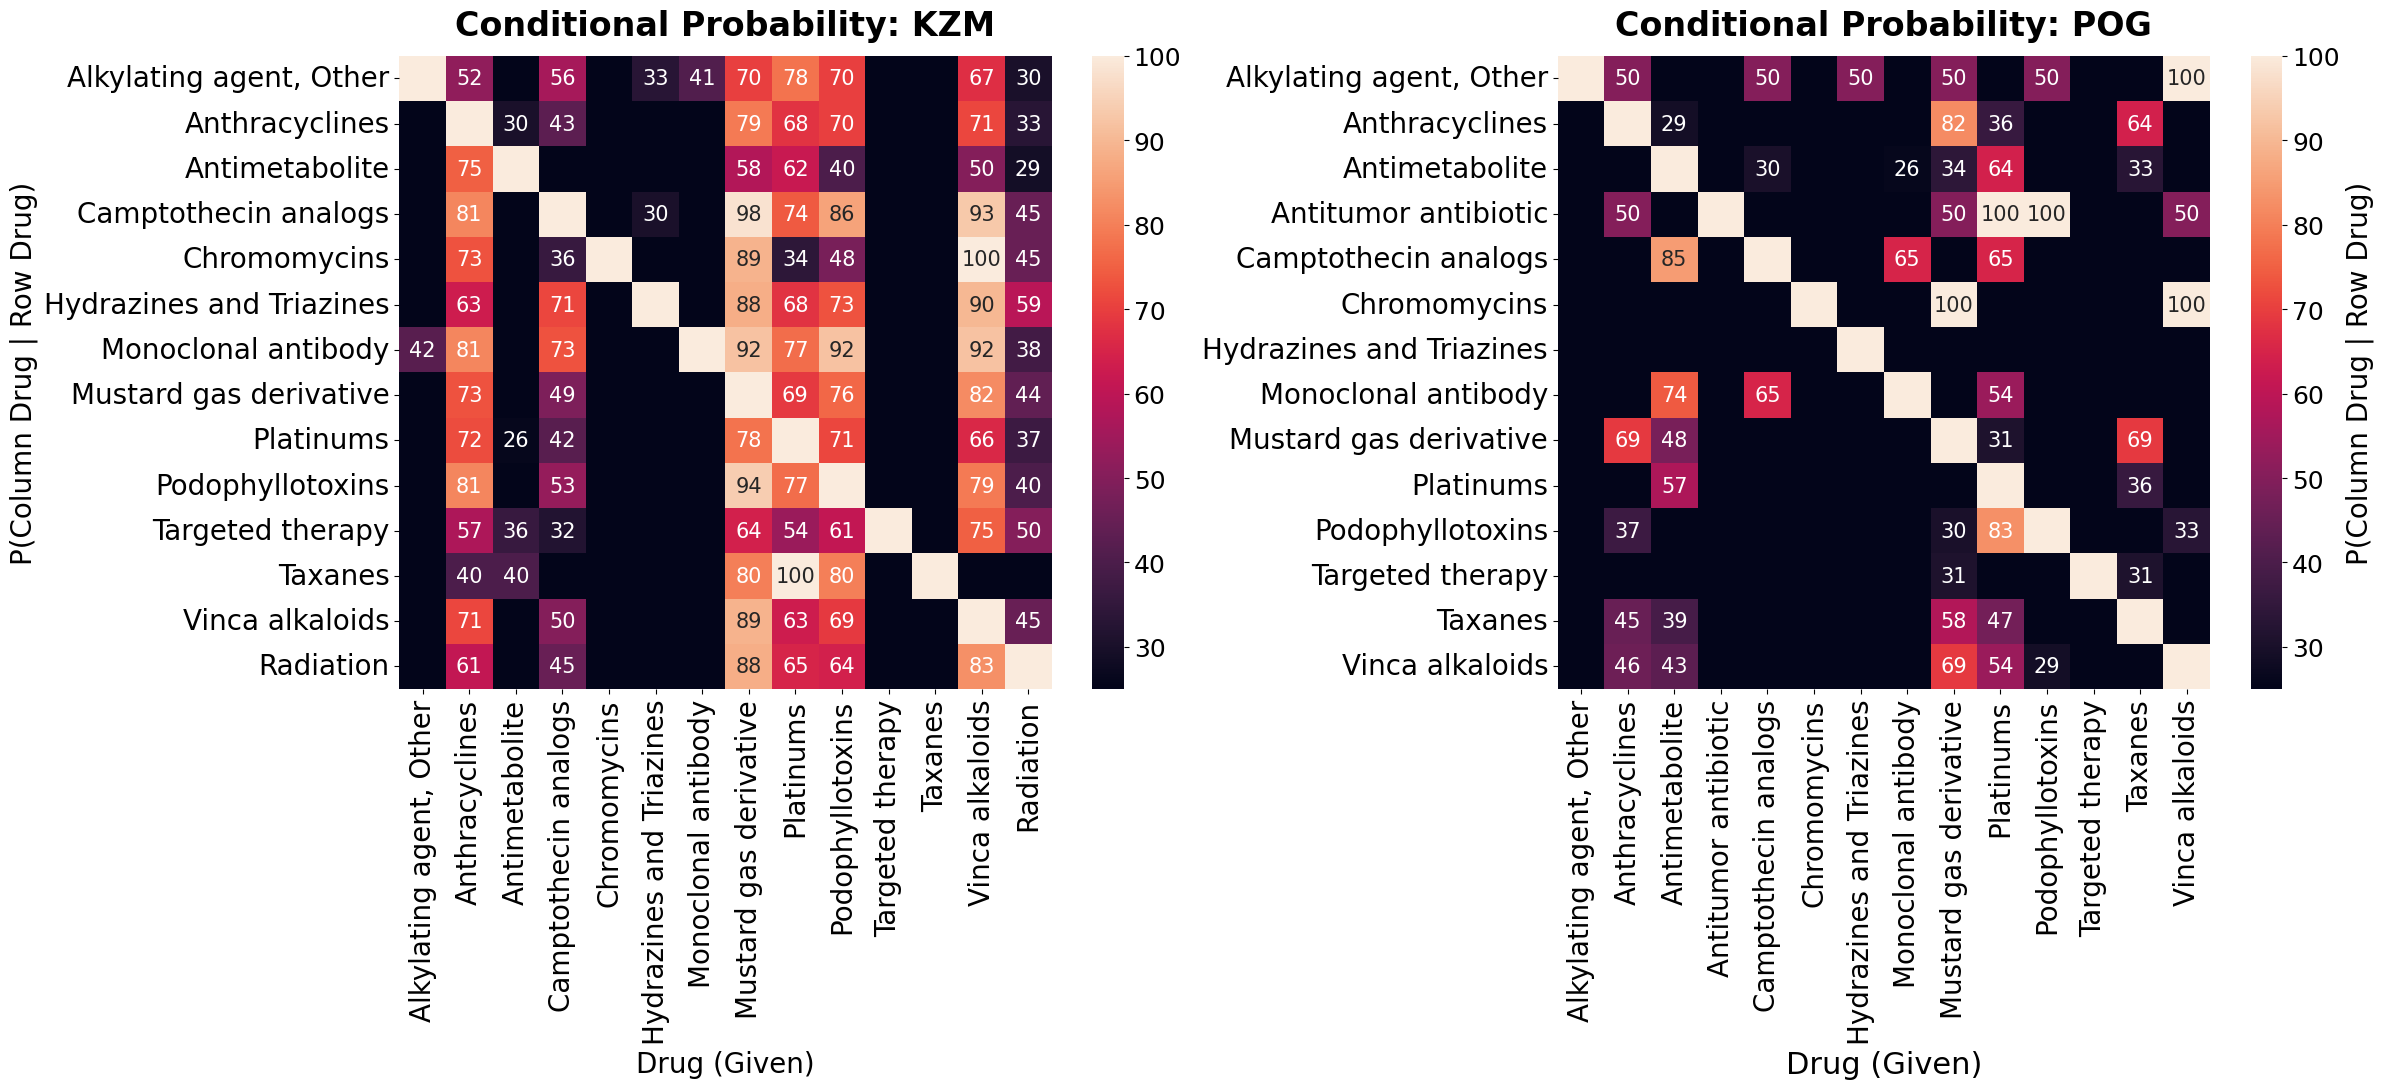

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your patient x drug binary matrix
# df.shape = (n_patients, n_drugs)

def calculate_conditional_prob(df):
    """
    Calculate P(col | row) = P(col AND row) / P(row)
    
    Result[i,j] = "Given a patient received drug i (row), 
                   what's the probability they also received drug j (col)?"
    """
    n_drugs = df.shape[1]
    cond_prob = np.zeros((n_drugs, n_drugs))
    
    for i, drug_i in enumerate(df.columns):
        for j, drug_j in enumerate(df.columns):
            # Patients who received drug_i
            patients_with_i = df[drug_i].sum()
            
            # Patients who received both drug_i AND drug_j
            patients_with_both = (df[drug_i] & df[drug_j]).sum()
            
            # P(drug_j | drug_i)
            if patients_with_i > 0:
                cond_prob[i, j] = patients_with_both / patients_with_i
            else:
                cond_prob[i, j] = 0
    
    return pd.DataFrame(cond_prob, index=df.columns, columns=df.columns)

def calculate_overlap_coefficient(df):
    """
    Calculate Overlap(A, B) = |A ∩ B| / min(|A|, |B|)
    
    Symmetric measure that focuses on the smaller set
    """
    n_drugs = df.shape[1]
    overlap = np.zeros((n_drugs, n_drugs))
    
    for i, drug_i in enumerate(df.columns):
        for j, drug_j in enumerate(df.columns):
            patients_with_i = df[drug_i].sum()
            patients_with_j = df[drug_j].sum()
            patients_with_both = (df[drug_i] & df[drug_j]).sum()
            
            min_count = min(patients_with_i, patients_with_j)
            if min_count > 0:
                overlap[i, j] = patients_with_both / min_count
            else:
                overlap[i, j] = 0
    
    return pd.DataFrame(overlap, index=df.columns, columns=df.columns)

df1 = kzm_class_hm.copy()
df1 = df1.drop(['Antitumor antibiotic'], axis=1)

df2 = pog_class_hm.copy()

# Calculate metrics
cond_prob_matrix_1 = calculate_conditional_prob(df1)
cond_prob_matrix_2 = calculate_conditional_prob(df2)

cond_prob_matrix_1 = (cond_prob_matrix_1 * 100).round(0)
cond_prob_matrix_2 = (cond_prob_matrix_2 * 100).round(0)


# Plot conditional probability (asymmetric)
fig, axes = plt.subplots(1,2, figsize=(24, 11))

ax1 = sns.heatmap(cond_prob_matrix_1, 
            annot=True,
            annot_kws={"size": 15},
            fmt='.0f', 
            #cmap='RdYlBu_r',
            vmin=25, 
            vmax=100,
            #cbar_kws={'label': 'P(Column Drug | Row Drug)', 'fontsize': 14},
            #cbar=False,
            ax=axes[0])
axes[0].set_title('Conditional Probability: KZM', pad=15, weight='bold', fontsize=24)
axes[0].set_xlabel('Drug (Given)', fontsize=20)
axes[0].set_ylabel('Drug (Conditioning on)', fontsize=22)

ax2 = sns.heatmap(cond_prob_matrix_2, 
            annot=True,
            annot_kws={"size": 15},
            fmt='.0f', 
            #cmap='RdYlBu_r',
            vmin=25, 
            vmax=100,
            #cbar_kws={'label': 'P(Column Drug | Row Drug)'},
            #cbar=False,
            ax=axes[1])
axes[1].set_title('Conditional Probability: POG', pad=15, weight='bold', fontsize=24)
axes[1].set_xlabel('Drug (Given)', fontsize=22)
#plt.ylabel('Drug (Conditioning on)')

ax1.figure.axes[0].set_ylabel('P(Column Drug | Row Drug)', size=20)
cbar1 = ax1.collections[0].colorbar
cbar1.ax.tick_params(labelsize=18)

ax2.figure.axes[-1].set_ylabel('P(Column Drug | Row Drug)', size=20)
cbar2 = ax2.collections[0].colorbar
cbar2.ax.tick_params(labelsize=18)

plt.setp(axes[0].get_xticklabels(), horizontalalignment='center', fontsize=20)
plt.setp(axes[1].get_xticklabels(), horizontalalignment='center', fontsize=20)
plt.setp(axes[0].get_yticklabels(), fontsize=20)
plt.setp(axes[1].get_yticklabels(), fontsize=20)

'''for t in ax1.texts:
    if float(t.get_text())>=0.25:
        t.set_text(t.get_text())
    else:
        t.set_text("")
for t in ax2.texts:
    if float(t.get_text())>=0.25:
        t.set_text(t.get_text())
    else:
        t.set_text("")'''

# Remove diagonal + apply threshold filter
n = cond_prob_matrix_1.shape[0]

for idx, t in enumerate(ax1.texts):
    i = idx // n
    j = idx % n
    if i == j:
        t.set_text("")  # remove diagonal annotation
    else:
        if float(t.get_text()) < 25:
            t.set_text("")

n2 = cond_prob_matrix_2.shape[0]

for idx, t in enumerate(ax2.texts):
    i = idx // n2
    j = idx % n2
    if i == j:
        t.set_text("")  # remove diagonal annotation
    else:
        if float(t.get_text()) < 25:
            t.set_text("")


fig.tight_layout()
plt.savefig(os.path.join(fig_out, 'ExFig_8b_rev.pdf'), bbox_inches="tight")

In [83]:
cond_prob_matrix_1 *100

,"Alkylating agent, Other",Anthracyclines,Antimetabolite,Camptothecin analogs,Chromomycins,Hydrazines and Triazines,Monoclonal antibody,Mustard gas derivative,Platinums,Podophyllotoxins,Targeted therapy,Taxanes,Vinca alkaloids,Radiation
"Alkylating agent, Other",100.000000,51.851852,7.407407,55.555556,0.000000,33.333333,40.740741,70.370370,77.777778,70.370370,7.407407,0.000000,66.666667,29.629630
Anthracyclines,7.692308,100.000000,29.670330,43.406593,17.582418,14.285714,11.538462,79.120879,68.131868,70.329670,8.791209,1.098901,71.428571,32.967033
Antimetabolite,2.777778,75.000000,100.000000,4.166667,0.000000,2.777778,8.333333,58.333333,62.500000,40.277778,13.888889,2.777778,50.000000,29.166667
Camptothecin analogs,15.306122,80.612245,3.061224,100.000000,16.326531,29.591837,19.387755,97.959184,74.489796,85.714286,9.183673,0.000000,92.857143,44.897959
Chromomycins,0.000000,72.727273,0.000000,36.363636,100.000000,11.363636,0.000000,88.636364,34.090909,47.727273,11.363636,0.000000,100.000000,45.454545
Hydrazines and Triazines,21.951220,63.414634,4.878049,70.731707,12.195122,100.000000,14.634146,87.804878,68.292683,73.170732,9.756098,0.000000,90.243902,58.536585
Monoclonal antibody,42.307692,80.769231,23.076923,73.076923,0.000000,23.076923,100.000000,92.307692,76.923077,92.307692,15.384615,0.000000,92.307692,38.461538
Mustard gas derivative,9.644670,73.096447,21.319797,48.730964,19.796954,18.274112,12.182741,100.000000,68.527919,76.142132,9.137056,2.030457,82.233503,43.654822
Platinums,12.138728,71.676301,26.011561,42.196532,8.670520,16.184971,11.560694,78.034682,100.000000,71.098266,8.670520,2.890173,66.473988,36.994220
Podophyllotoxins,11.949686,80.503145,18.238994,52.830189,13.207547,18.867925,15.094340,94.339623,77.358491,100.000000,10.691824,2.515723,78.616352,39.622642
